## Temperature Evolution

This notebook performs energy minimization for a system of particles interacting via the Lennard-Jones potential and performes a calculation of the temperature evolution:

## Configuration Parameters (via `Configuration` class):
- `dimensions`: Simulation dimensionality (2D or 3D)
- `n_particles`: Number of particles in the simulation
- `density`: Number density of particles
- `dt`: Timestep used during minimization
- `steps`, `minimization_steps`: Total number of simulation or minimization steps
- `use_pbc`: Enable/disable periodic boundary conditions
- `temperature`: Initial or target temperature
- `sigma`, `epsilon`: Lennard-Jones potential parameters
- `rcutoff`: Cutoff radius for LJ interactions
- `use_lca`: Use the linked-cell algorithm for force computation
- `minimize_only`: Whether to run minimization only (no dynamics)

## Key Functions and Return Values:
- `compute_lj_force(r, sigma, epsilon, rcutoff)`: Returns the scalar Lennard-Jones force at distance `r`
- `compute_lj_potential(r, sigma, epsilon, rcutoff)`: Returns the shifted Lennard-Jones potential energy
- `build_linked_cells(positions, box_size, rcutoff)`: Constructs head and linked-cell list arrays for neighbor searching
- `compute_forces_lca(...)`: Computes particle forces and potential energy using the linked-cell algorithm
- `Simulation.minimize_energy()`: Runs steepest descent minimization and returns lists of potential energy, kinetic energy, and temperature

## Simulation:
- Initializes particle positions in a lattice within a periodic box
- Computes initial forces using the Lennard-Jones potential
- Performs normalized steepest descent energy minimization
- Monitors temperature during the minimization process
- Plots the evolution of temperature over time
- Analyzes and visualizes the temperature distribution in the final (stable) part of the trajectory

## Parameters:
- `dimensions`: 3  
- `n_particles`: 1000  
- `density`: 0.8  
- `dt`: 0.001  
- `steps`: 1000  
- `minimization_steps`: 1000  
- `use_pbc`: True  
- `temperature`: 1.0  
- `sigma`: 1.0  
- `epsilon`: 1.0  
- `rcutoff`: 2.5  
- `use_lca`: True  
- `minimize_only`: True 


Step  999 | PE: -5249.643523 | KE: 61.707482 | Temp: 0.0411


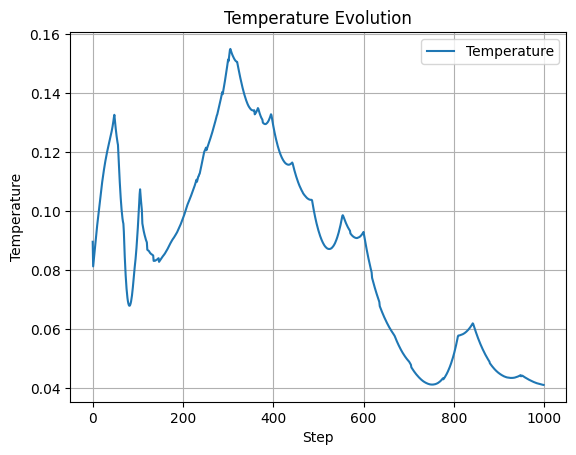

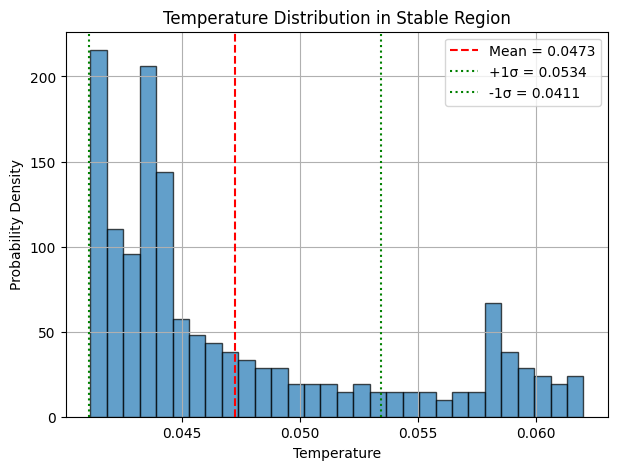

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def compute_lj_force(r, sigma, epsilon, rcutoff):
    if r >= rcutoff or r < 1e-12:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    return 24 * epsilon * (2 * inv_r12 - inv_r6) / r

def compute_lj_potential(r, sigma, epsilon, rcutoff):
    if r >= rcutoff:
        return 0.0
    inv_r = sigma / r
    inv_r6 = inv_r ** 6
    inv_r12 = inv_r6 ** 2
    pot = 4 * epsilon * (inv_r12 - inv_r6)
    inv_rcut = sigma / rcutoff
    shift = 4 * epsilon * (inv_rcut ** 12 - inv_rcut ** 6)
    return pot - shift

def build_linked_cells(positions, box_size, rcutoff):
    n_particles, dim = positions.shape
    lc = max(1, int(np.floor(box_size / rcutoff)))
    lc_dim = [lc] * dim
    rc = box_size / lc
    EMPTY = -1

    head = [EMPTY] * (lc ** dim)
    lscl = [EMPTY] * n_particles

    for i in range(n_particles):
        mc = [int(positions[i][a] / rc) for a in range(dim)]
        mc = [min(max(0, idx), lc - 1) for idx in mc]
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        lscl[i] = head[c_index]
        head[c_index] = i

    return head, lscl, lc_dim

def compute_forces_lca(positions, box_size, rcutoff, sigma, epsilon, use_pbc):
    n_particles, dim = positions.shape
    head, lscl, lc_dim = build_linked_cells(positions, box_size, rcutoff)
    EMPTY = -1
    forces = np.zeros_like(positions)
    potential_energy = 0.0
    neighbor_offsets = np.array(np.meshgrid(*[[-1, 0, 1]] * dim)).T.reshape(-1, dim)

    for mc in np.ndindex(*lc_dim):
        if dim == 2:
            c_index = mc[0] * lc_dim[1] + mc[1]
        else:
            c_index = mc[0] * lc_dim[1] * lc_dim[2] + mc[1] * lc_dim[2] + mc[2]
        i = head[c_index]
        while i != EMPTY:
            pos_i = positions[i]
            for offset in neighbor_offsets:
                mc1 = np.array(mc) + offset
                rshift = np.zeros(dim)
                valid_cell = True
                for a in range(dim):
                    if use_pbc:
                        if mc1[a] < 0:
                            mc1[a] += lc_dim[a]
                            rshift[a] = -box_size
                        elif mc1[a] >= lc_dim[a]:
                            mc1[a] -= lc_dim[a]
                            rshift[a] = box_size
                    else:
                        if mc1[a] < 0 or mc1[a] >= lc_dim[a]:
                            valid_cell = False
                            break
                if not valid_cell:
                    continue
                if dim == 2:
                    c1 = mc1[0] * lc_dim[1] + mc1[1]
                else:
                    c1 = mc1[0] * lc_dim[1] * lc_dim[2] + mc1[1] * lc_dim[2] + mc1[2]
                j = head[c1]
                while j != EMPTY:
                    if j > i:
                        pos_j = positions[j] + rshift
                        r_ij = pos_i - pos_j
                        dist = np.linalg.norm(r_ij)
                        if dist < rcutoff and dist > 1e-12:
                            f_mag = compute_lj_force(dist, sigma, epsilon, rcutoff)
                            fij = f_mag * (r_ij / dist)
                            forces[i] += fij
                            forces[j] -= fij
                            potential_energy += compute_lj_potential(dist, sigma, epsilon, rcutoff)
                    j = lscl[j]
            i = lscl[i]

    return forces, potential_energy

class Configuration:
    def __init__(self):
        self.dimensions = 3
        self.n_particles = 1000
        self.density = 0.8
        self.dt = 0.001
        self.steps = 1000
        self.use_pbc = True
        self.temperature = 1.0
        self.sigma = 1.0
        self.epsilon = 1.0
        self.rcutoff = 2.5
        self.minimize_only = True
        self.minimize = True
        self.minimization_steps = 1000
        self.use_lca = True

class Simulation:
    def __init__(self, config: Configuration):
        self.config = config
        self.dimensions = config.dimensions
        self.n_particles = config.n_particles
        self.density = config.density
        self.dt = config.dt
        self.use_pbc = config.use_pbc
        self.temperature = config.temperature
        self.sigma = config.sigma
        self.epsilon = config.epsilon
        self.rcutoff = config.rcutoff
        self.minimization_steps = config.minimization_steps
        self.use_lca = config.use_lca

        self.box_size = self.compute_box_size()
        self.positions = self.create_lattice()
        self.velocities = np.zeros((self.n_particles, self.dimensions))
        self.forces, self.potential_energy = self.compute_forces()

    def compute_box_size(self):
        return (self.n_particles / self.density) ** (1 / self.dimensions)

    def create_lattice(self):
        n_side = int(np.ceil(self.n_particles ** (1 / self.dimensions)))
        spacing = self.box_size / n_side
        positions = []

        for indices in np.ndindex(*([n_side] * self.dimensions)):
            if len(positions) < self.n_particles:
                pos = [(i + 0.5) * spacing for i in indices]
                noise = np.random.uniform(-0.05, 0.05, size=self.dimensions) * spacing
                pos = np.array(pos) + noise
                positions.append(pos)
        return np.array(positions)

    def apply_boundary_conditions(self, positions):
        if self.use_pbc:
            return positions % self.box_size
        else:
            for i in range(self.n_particles):
                for dim in range(self.dimensions):
                    if positions[i, dim] < 0:
                        positions[i, dim] = -positions[i, dim]
                    elif positions[i, dim] > self.box_size:
                        positions[i, dim] = 2 * self.box_size - positions[i, dim]
            return positions

    def compute_forces(self):
        if self.use_lca:
            return compute_forces_lca(self.positions, self.box_size, self.rcutoff,
                                      self.sigma, self.epsilon, self.use_pbc)
        else:
            raise NotImplementedError("Naive force version not implemented in this snippet.")

    def minimize_energy(self):
        self.velocities = np.zeros_like(self.positions)
        self.use_pbc = False

        pe_list = []
        ke_list = []
        temp_list = []

        for step in range(self.minimization_steps):
            max_force_component = np.max(np.abs(self.forces))
            if max_force_component == 0:
                break
            normalized_forces = self.forces / max_force_component
            new_positions = self.positions + self.dt * normalized_forces
            new_positions = self.apply_boundary_conditions(new_positions)
            new_velocities = (new_positions - self.positions) / self.dt

            self.positions = new_positions
            self.velocities = new_velocities
            self.forces, potential_energy = compute_forces_lca(
                self.positions, self.box_size, self.rcutoff,
                self.sigma, self.epsilon, self.use_pbc
            )

            kinetic_energy = 0.5 * np.sum(self.velocities ** 2)
            dof = self.n_particles * self.dimensions
            temperature = (2 * kinetic_energy) / dof

            pe_list.append(potential_energy)
            ke_list.append(kinetic_energy)
            temp_list.append(temperature)

            if step % 50 == 0 or step == self.minimization_steps - 1:
                clear_output(wait=True)
                print(f"Step {step:4d} | PE: {potential_energy:.6f} | KE: {kinetic_energy:.6f} | Temp: {temperature:.4f}")

        return pe_list, ke_list, temp_list


config = Configuration()
sim = Simulation(config)
pe_list, ke_list, temp_list = sim.minimize_energy()

plt.plot(temp_list, label="Temperature")
plt.xlabel("Step")
plt.ylabel("Temperature")
plt.title("Temperature Evolution")
plt.grid(True)
plt.legend()
plt.show()


stable_fraction = 0.3
n_temp = len(temp_list)
start_index = int(n_temp * (1 - stable_fraction)) if n_temp > 0 else 0
stable_temperatures = np.array(temp_list[start_index:])

if len(stable_temperatures) > 0:
    mean_temp = np.mean(stable_temperatures)
    std_temp = np.std(stable_temperatures)

    plt.figure(figsize=(7, 5))
    plt.hist(stable_temperatures, bins=30, density=True, alpha=0.7, edgecolor='black')
    plt.axvline(mean_temp, color='red', linestyle='--', label=f'Mean = {mean_temp:.4f}')
    plt.axvline(mean_temp + std_temp, color='green', linestyle=':', label=f'+1σ = {mean_temp + std_temp:.4f}')
    plt.axvline(mean_temp - std_temp, color='green', linestyle=':', label=f'-1σ = {mean_temp - std_temp:.4f}')
    plt.title("Temperature Distribution in Stable Region")
    plt.xlabel("Temperature")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No temperature data available.")
